<a href="https://colab.research.google.com/github/Nichlas0403/DL_Multi_Image_Classification_Dog_Breeds/blob/main/DL_image_multi_classification_Dog_breeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class dog breed classification

This notebook builds an end-to-end multi-class image classifier
using Tensorflow 2.0 and Tensorflow Hub.

## 1. Problem

Identifying the breed of a dog given a picture of it.

## 2. Data

The data is provided by Kaggle's Dog Breed Competiton.

https://www.kaggle.com/c/dog-breed-identification/data 

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed
of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features

Information about the data:

* Data is in the form of images (unstructured data), so we'll use 
deep learning / transfer learning.
* There are 120 breeds of dogs (which means there are 120
different classes).
* There are around 10000+ different training images
(these images have labels)
* There are around 10000+ different images in the test set
(these images have no labels, since we want to predict them)

In [ ]:
# unzip the data into google drive

#!unzip "/content/drive/My Drive/Dog Vision/dog-breed-identification.zip" -d "/content/drive/My Drive/Dog Vision"

### Get our workspace ready

* Import tensorflow
* Import tensorflow Hub (here is our ML models)
* Make sure we're using a GPU
  To use GPU: Go to RunTime, Change runtime type, GPU

In [ ]:
# Import tensorflow
import tensorflow as tf

#Check version
print("TF version: " + tf.__version__)

import tensorflow_hub as hub
print("Hub version: " + hub.__version__)

#Check for GPU availability
print("GPU", "available (Yes)" if tf.config.list_physical_devices("GPU") else "Not available")

TF version: 2.3.0
Hub version: 0.8.0
GPU available (Yes)


# 1. Data exploration analysis

Let's see what is in out data

#### Access data and check labels

In [ ]:
import pandas as pd

#Import labels (this might take a while)

labels_csv = pd.read_csv("/content/drive/My Drive/Dog Vision/labels.csv")
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     bfd383676d64ac4b280719a0ef6e48b4  scottish_deerhound
freq                                   1                 126

In [ ]:
labels_csv.head()
#These ID's are the name of the image file
#You can see that later

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

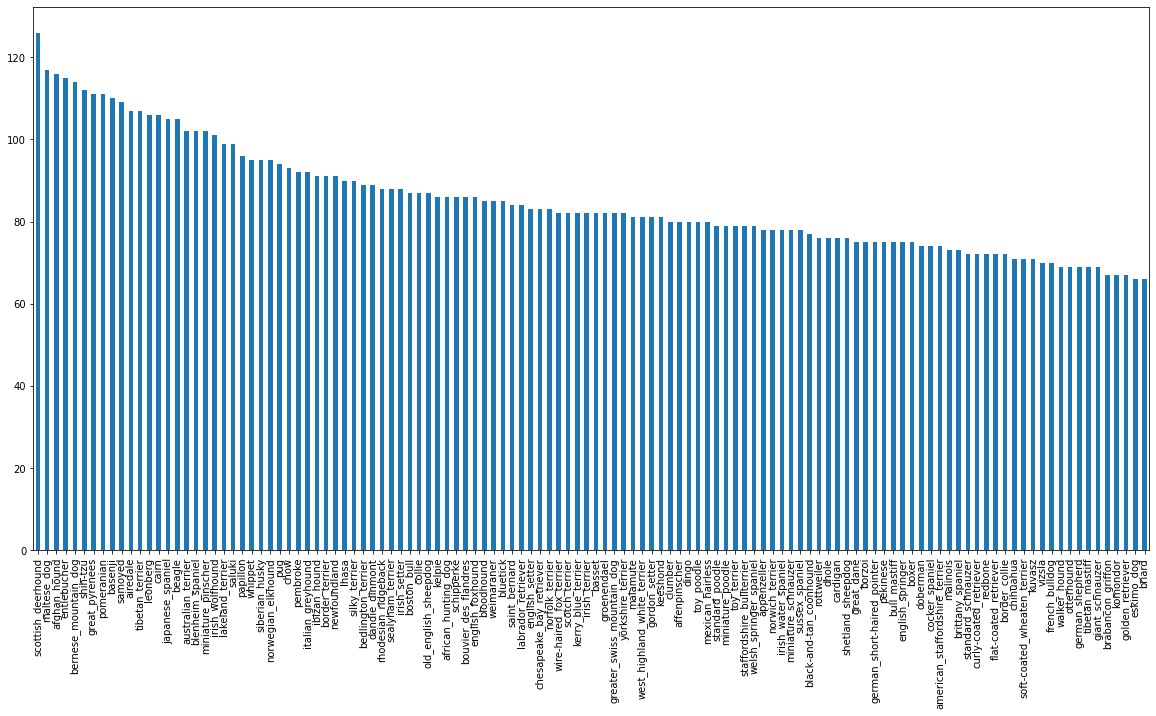

In [ ]:
# Check how many images there are of each breed
# These are pretty well spread out

labels_csv["breed"].value_counts().plot.bar(figsize=(20,10));

In [ ]:
# Median of dogbreeds
labels_csv["breed"].value_counts().median()

82.0

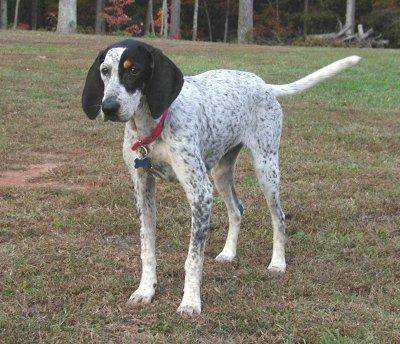

In [ ]:
# Let's view an image

from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

#The long ID in the string above is the id from the csv file

In [ ]:
#find ids with german shepherds
labels_csv[labels_csv["breed"] == "german_shepherd"]

id            breed
60    016bcdb05e2d0e0878877df21b8c3cff  german_shepherd
68    01b09bdac592b0eb9909dd105314ad3a  german_shepherd
243   05a05cf4c8d6a4f3f780a9112a11999b  german_shepherd
454   0ac12e1849fd51b2158d16b8f5e75551  german_shepherd
774   1321d074e879267699d42fdca77b4004  german_shepherd
...                                ...              ...
9391  eba058daca887257dc71bfd2a0267d29  german_shepherd
9411  ec14673c74fc8c62ee54ab67c9daf010  german_shepherd
9433  ecaec07d20ed3a12fc32314cf83c9370  german_shepherd
9471  ed87717fd2068ed2c909afa65a2cfe2e  german_shepherd
9824  f738d8472928f06c5a3743914ac5d458  german_shepherd

[69 rows x 2 columns]

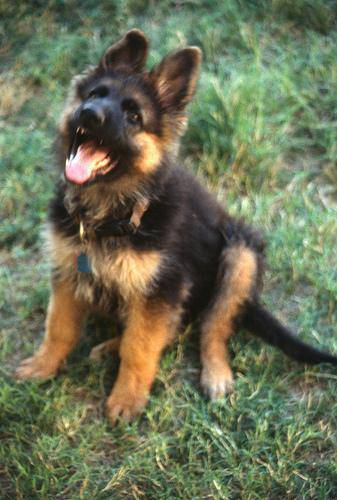

In [ ]:
Image("drive/My Drive/Dog Vision/train/016bcdb05e2d0e0878877df21b8c3cff.jpg")

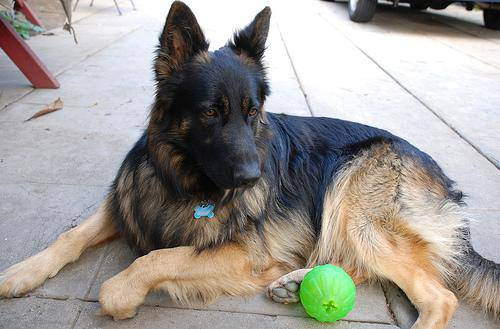

In [ ]:
Image("drive/My Drive/Dog Vision/train/01b09bdac592b0eb9909dd105314ad3a.jpg")

# Organize data

In this section we'll be doing a few things:

* Save sample filenames and path to them in a list
* Save unique breednames to a list, so we can turn our sample breed value into
  a numerical value.
  How? We got all 120 breed names in one list. The value of the samples breed
  column will then be a list of booleans which correlates to the list of breeds.
  So each sample breed value holds a list of 119 False and one True.
  So if the breed[2] = german_shepherd, and a sample is a german shepherd, it's
  breed value will be False, False, True, False, False...

In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
#Create list from Image ID's

filenames = ["drive/My Drive/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

#Check first 10
filenames[:10]

['drive/My Drive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
#Check wether number of filenames matches number of actual image files

import os

#os.listdir() iterates through a directory and returns a list with the content

#Checks if we have all the training samples in the filenames list
if len(os.listdir("drive/My Drive/Dog Vision/train/")) == len(filenames):
  print("True")
else:
  print("False")

True


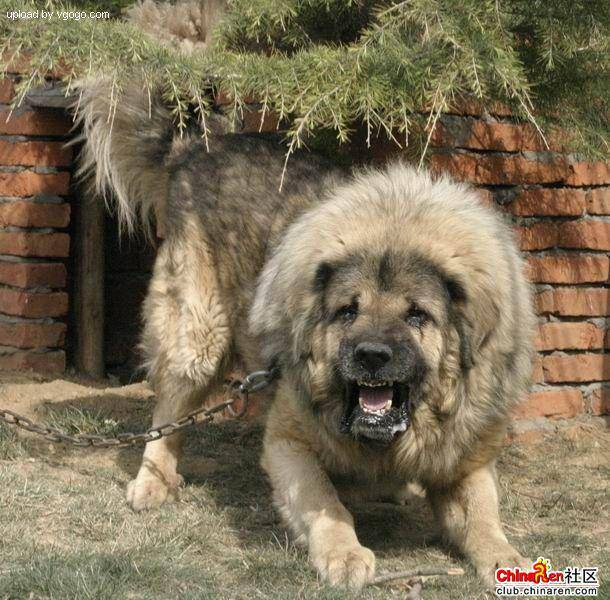

In [ ]:
#Double check we actually have the filepath in the list
#This is sample number 9000
Image(filenames[9000])

In [ ]:
labels_csv["breed"][9000]

'tibetan_mastiff'


#### Prepare labels so we can turn it into tensors

We now got our training image filpaths in a list, let's prepare our labels

In [ ]:
#Put labels into a list

labels = labels_csv["breed"]
labels

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

In [ ]:
#Import and use numpy

import numpy as np
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
#Same size
len(filenames), len(labels)

#They need to be the same size, since we need to match them with eachother

(10222, 10222)

In [ ]:
#Find the unique label values
breeds = np.unique(labels)
breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
#Kaggle says there should be 120 breeds 
len(breeds)

120

In [ ]:
#Turn a single label into an array of boolean which correlates to the breeds-list
print(labels[0])
labels[0] == breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
  #Now do it for every sample
  boolean_labels = [label == breeds for label in labels]
  boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
labels[0] #The breed of all samples. Choosing index 0

'boston_bull'

In [ ]:
breeds[:5] #All the breeds. Showing first five

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier'], dtype=object)

In [ ]:
#Example: Turning boolean array into integers:
print(labels[0]) #Original labels
print(np.where(breeds == labels[0])) #Index where label occours
print(boolean_labels[0].argmax()) #Index where label occours in boolean array
print(boolean_labels[0].astype(int)) #There will be 1 where True is in 
#boolean_labels

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


#### Create our own validation set

The dataset from Kaggle does not come with a validation set, so we
will create our own

We got quite a lot of samples (over 10000), and they are even in jpg format.
It will take a long time to train the model on this, so we will work with a
subsample of the training data, until we can identify the optimal
model parameters

In [ ]:
#Create X and y
X = filenames
y = boolean_labels

In [ ]:
#Set the number of images to use for experimenting
#We're using the conventional naming. If we create
#variables which are adjustable like below, we will
#name the variable in higher case

#We can create a slider to adjust the value of the variable!!!!
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
#Split data into test and validation

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

#Check the size
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
#Let's see the training data
X_train[:3], y_train[:3]

(['drive/My Drive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,

#### Preprocessing images by turning them into Tensors
Tensors are numerical representations

To preprocess images into tensors, we're going to make a function
which does a few things:

1. Take an image filepath as input
2. Use tensorflow to read the file and save it to a variable 'image'
3. We want to turn our image variable (a jpg) into tensors
4. Normalize our image (convert color channel values fra 0-255 to 0-1
5. Resize the image to a standard size of (224,224) (common practice)
6. Return the modified image

But first, let's see what importing an image looks like

In [ ]:
#Convert image to NumPy array 
from matplotlib.pyplot import imread
image = imread(filenames[7])
image.shape

(227, 231, 3)

In [ ]:
image.min(), image.max()

(0, 255)

In [ ]:
#Turn image into tensor
tf.constant(image)[:5]

<tf.Tensor: shape=(5, 231, 3), dtype=uint8, numpy=
array([[[ 76,  97,  58],
        [ 80, 101,  62],
        [ 84, 104,  67],
        ...,
        [ 66,  83,  51],
        [ 66,  83,  49],
        [ 36,  53,  17]],

       [[ 91, 112,  73],
        [ 94, 115,  76],
        [ 93, 113,  76],
        ...,
        [ 89, 102,  74],
        [ 83,  96,  66],
        [ 71,  85,  52]],

       [[ 84, 105,  66],
        [ 93, 114,  75],
        [ 98, 118,  81],
        ...,
        [ 74,  82,  58],
        [ 58,  66,  42],
        [ 81,  90,  63]],

       [[ 82, 100,  62],
        [ 86, 103,  67],
        [ 88, 105,  69],
        ...,
        [126, 129, 110],
        [ 69,  72,  53],
        [ 61,  64,  45]],

       [[ 96, 113,  77],
        [ 88, 105,  69],
        [ 77,  94,  58],
        ...,
        [137, 135, 123],
        [ 88,  86,  74],
        [ 57,  55,  43]]], dtype=uint8)>

##### Preprocessing function

In [ ]:
#Define image size
IMG_SIZE = 224

#Create a function for preprocessing images

def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """

  #Read an image file path and turns into a Tensor
  #in string format
  image = tf.io.read_file(image_path)

  #Turns the tensor-string into a numerical tensor format (which looks
  #a lot like a numpy array). The value is equal to the color code in
  #the picutre

  image = tf.image.decode_jpeg(image, channels=3) #3 for red, green and blue

  #Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  #Depending on the picture, it will have a certain size. We need all
  #our data to be of the same size, so the machine can find a patternt
  #between them. 
  #Resize the image to (224,224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])


  return image

#### Turning data into batches

Why turn our data into batches?

Let's say you're trying to process 10000+ images in on go.
They all might not fit into memory!

So a solution, is to process them in batches with about 32 images.
You can manually adjust the batchsize if needed

In order to use Tensorflow effectively, we need our data in the form
of Tensor tuples which look like this:

'(image, lable)'

##### Function to return a tuple

In [ ]:
# Create a simple function to return a tuple (image, label)

def get_image_label(image_path, label):
  """
  Takes an image file path and the associated label:
  The image will be turned into a string tensor, then
  a numerical tensor based on the pictures colorcode.
  The values will be changed from 0-255 to 0-1.
  The picturesize will be resized to (244,244)

  Returns this product, with the label in
  a tupel
  
  """
  image = process_image(image_path)
  return image, label

Now we've got a way to transform our data into tuples of Tensors
in the form (image, label).
We'll now make a function to turn X and y into batches

##### Function to create batches

This function will take X and y and return a preprocessed batch (it uses the other preprocess function we created)

In [ ]:
#Define the batchsize, 32 is a good start

BATCH_SIZE = 32

#Create a function to turn data into batches
def create_data_batches(X,y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if
  it's validation data.
  Also accepts test data as input (no labels)
  """

  if test_data == True:

    print("Creating test data batches...")

    #Creates a tensorflow dataset frem the tensorslices X
    #Only filepaths - no labels!

    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)

    return data_batch

    #If the data is a val datasæt, we don't need to shuffle it.

  elif valid_data == True:

    print("Creating validation data batches...")

    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #Filepaths
                                               tf.constant(y))) #Labels
    
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)

    return data_batch

  else:
    print("Creating training data batches")

    #Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    
    #Shuffle labels + pathnames
    data = data.shuffle(buffer_size=len(X)) 

    #Create image label tupels (altso turn imagepath into preprocessed image)
    data = data.map(get_image_label)

    #Turn training data into batches
    data_batch = data.batch(BATCH_SIZE)

    return data_batch

In [ ]:
#Create training and validation data batches

train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)


Creating training data batches
Creating validation data batches...


In [ ]:
#Check the different attributes of data batches
train_data.element_spec

#Første linje er vores image (X) i form af tensor - None er for batchsize 
#(de er sat til 32, men
#batchsize er fleksible, så derfor står der None). 224,224 er størrelsen vi har
#givet dem, og 3 er for vores colorcode.

#Under er vores label (y) i form af tensors - igen batchsize 32 selvom der står
#None. Størrelsen er 120, fordi længden af vores breed list er 120 (se under)

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))

In [ ]:
y[0], len(y[0])

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]), 120)

#### Visualize data batches

Our data is now in batches, however these can be a little hard to grasp. Let's visualize them.

In [ ]:
import matplotlib.pyplot as plt

##### View image in databatch function

In [ ]:
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a databatch
  """

  #Setup figur
  plt.figure(figsize=(10,10))

  #Loop though 25 for displaying 25 images

  for i in range(25):
    #Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5,5,i+1)

    #Display an image¨
    plt.imshow(images[i])

    #Add image label as the title
    plt.title(breeds[labels[i].argmax()])

    #Turn grid line off
    plt.axis("off")

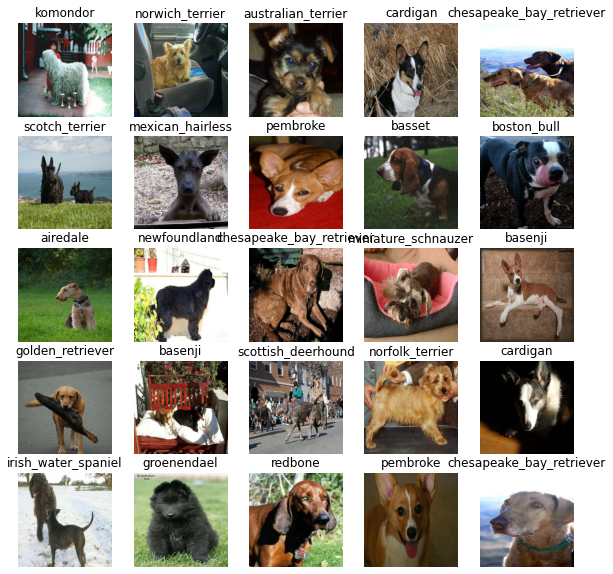

In [ ]:
  # Now let's visualize the data in a training batch
  train_images, train_labels = next(train_data.as_numpy_iterator())
  show_25_images(train_images, train_labels) 

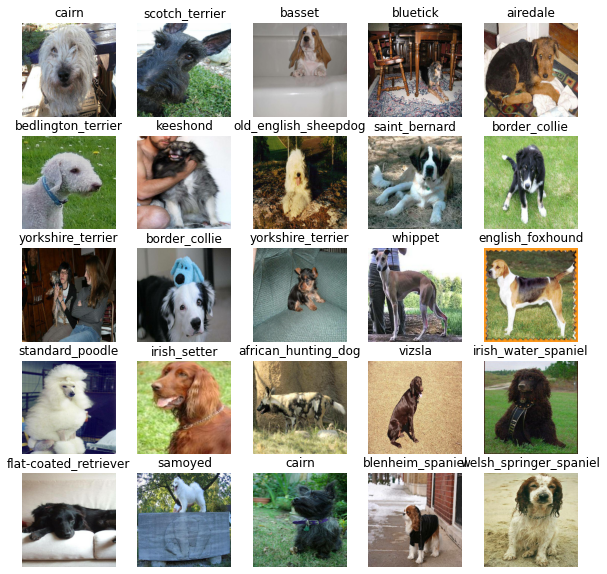

In [ ]:
#Visualize validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels) 

# Building a model

Before we build a model, there are a few things we need to define:

* The input shape (our images shape in the form of tensors) to our model
* The output shape (labels) in the form of tensors
* The URL of the model we want to use
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [ ]:
#Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]

#Setup output shape of the model
OUTPUT_SHAPE = len(breeds)

In [ ]:
#Setup model URL from tensorflow hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

#### Keras API

We now got input, output and the model ready to go. We'll use keras API to put it all together into a keras deep learning model

##### Function to use Keras

The function will:
* Take the input, output and the model we've chosen.
* Define the layers in the keras model in a sequential fashion (a linear fashion. Do this, then that)
* Compile the model (says it should be evaluated and improved)
* Build the model (tells the model the input shape it'll get)
* Returns the model

These steps can be found here:

www.tensorflow.org/guide/keras/overview

In [ ]:
#Create function

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with: " + model_url)

  #Via tf.keras.Sequential kan vi opsætte en sekventiel model.
  model = tf.keras.Sequential([
      #hub.KerasLayer bruger modellen fra vores URL
      #I den model eksisterer der allerede hidden layers, der er lavet.
      #Derfor definerer vi kun to lag. Input og output. det er styrke ved 
      #Transfer learning
      hub.KerasLayer(model_url),#Layer 1 (input)
      #Her fortæller vi hvad vores output skal være.
      #Vi har sat det til at være 120, da det er vores antal forskellige labels.
      #Så vores output ligger i et array af 120 elementer. Højeste værdi her 
      #bliver så vores label
      #softmax gør at alle output komponenter bliver et tal fra 0-1
      tf.keras.layers.Dense(units=output_shape,
                           activation="softmax")])  #Layer 2 (output)


  #Compile the model
  model.compile(
      #loss måler hvornår modellen lærer. Højere loss = værre predictions
      loss=tf.keras.losses.CategoricalCrossentropy(),
      #Adam er en instruktør, en optimiser. Den fortæller hvordan man kan 'lower
      #the lossfunction', så hvordan modellen forbedrer sig.
      #Adam() er en god general optimizer. 
      optimizer=tf.keras.optimizers.Adam(),
      #Metrics er dommeren, der måler modellens performance. Her mål den vores
      #models accuracy i at vælge det rigtige label.
      metrics=["accuracy"]
  )

  #Build the model with the desired input shape
  model.build(input_shape)

  return model

In [ ]:
model=create_model()
model.summary()
#Params 5432713 er de patterns vores model allerede har lært (vi bruger transfer 
#learning). Det er altså vores baselayer modellen på forhånd kender. 
#Vi slipper nu for selv at bruge flere timer og store mængder computerkraft, på
#selv at finde de patterns. I stedet kan vi udnytte transferlearning, og bruge
#de allerede fundne patterns, på vores 120,240 params.

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


##### Create callbacks

Callbacks are helper functions a model can use during training
to do such things as save its progress, check its progress or
stop training early if the model stops improving. A lot more can be implementet, but this is a start.

We'll create two callbacks:
* One for TensorBoard which helps track our models progress
* One for early stopping which prevents our model from training for too long

###### TensorBoard callback

We need to do three things

1. Load tensorboard extension
2. Create a tensorboard callback which can save logs to a directory and pass it to our models fit-function
3. Visualize our model's traininglogs with a tensorboard magic function - we'll do this after training

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [ ]:
#Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():

  #Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/My Drive/Dog Vision/logs",
                        #Make so our logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  
  return tf.keras.callbacks.TensorBoard(logdir)

###### Early stopping callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluationmetric stops improving.

In [ ]:
# Create early stopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

#### Training a model

First model will be done on a subset of the data (1000 images), to make sure everything is working.

In [ ]:
#1 epoch er én chance modellen får til at træne sig selv.
#Vi giver den 100
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}


In [ ]:
# Check to make sure we're still running on a GPU
if tf.config.list_physical_devices("GPU"):
  print(True)
else:
  print(False)

True


##### Create functions which trains a model

* Create model using create_model()
* Setup a Tensorboard callback using 'create_tensorboard_callback()'
* Call the 'fit()' function on our model, passing it the training data, validation data, number of epocs to train for (NUM_EPOCHS)
* Return a model

In [ ]:
#Build a function to train and return a mdoel

def train_model():
  """
  Trains a given model and returns a trained version.
  """
  #Create a model
  model = create_model()

  #Create new tensorboard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  #Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data, #træningsdata
            epochs=NUM_EPOCHS, #antal chancer modellen får
            validation_data=val_data, #validation data
            validation_freq=1, #for hver epoc, må modellen kigge på validation
            callbacks=[tensorboard, early_stopping]) #vores callbacks
  
  return model

###### Train model on 1000 images (commented out now sinces the model has been saved)

In [ ]:
#Fit the model to the data
#model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
 1/25 [>.............................] - ETA: 0s - loss: 5.5863 - accuracy: 0.0000e+00WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


25/25 [==============================] - 506s 20s/step - loss: 4.4591 - accuracy: 0.1050 - val_loss: 3.2764 - val_accuracy: 0.2600
Epoch 2/100
25/25 [==============================] - 6s 257ms/step - loss: 1.5720 - accuracy: 0.6875 - val_loss: 2.0780 - val_accuracy: 0.5300
Epoch 3/100
25/25 [==============================] - 7s 261ms/step - loss: 0.5449 - accuracy: 0.9350 - val_loss: 1.5971 - val_accuracy: 0.6000
Epoch 4/100
25/25 [==============================] - 7s 260ms/step - loss: 0.2456 - accuracy: 0.9912 - val_loss: 1.4471 - val_accuracy: 0.6200
Epoch 5/100
25/25 [==============================] - 6s 259ms/step - loss: 0.1433 - accuracy: 0.9950 - val_loss: 1.3863 - val_accuracy: 0.6350
Epoch 6/100
25/25 [==============================] - 7s 261ms/step - loss: 0.0990 - accuracy: 1.0000 - val_loss: 1.3334 - val_accuracy: 0.6400
Epoch 7/100
25/25 [==============================] - 6s 259ms/step - loss: 0.0746 - accuracy: 1.0000 - val_loss: 1.3076 - val_accuracy: 0.6400
Epoch 8/100

###### Thoughts on the models performing

Clearly it's overfitting, which is good! It means our model is learning.

##### Check tensorboard logs

The TensorBoard magic function ('%tensorboard') will  accress the logs directory and visualize its contents. 

In [ ]:
#Giver det vores log path
#Fordi der er 'spaces' i nedenstående path, skal vi lave et 'omvendt' backslash
#foran det
%tensorboard --logdir /content/drive/My\ Drive/Dog\ Vision/logs

# Making and evaluating predictions using a trained model

In [ ]:
#Make predictions on the validationsdata
predictions = model.predict(val_data, verbose=1)
predictions

7/7 [==============================] - 1s 184ms/step


array([[1.2226119e-03, 3.2594646e-05, 5.8485027e-03, ..., 6.5275928e-04,
        2.6315091e-05, 9.0243021e-04],
       [1.3032493e-03, 4.4907737e-04, 1.1639292e-02, ..., 7.8438519e-04,
        3.9415699e-04, 2.8996647e-04],
       [1.2301208e-05, 4.0748029e-05, 4.1096220e-05, ..., 4.2277923e-05,
        1.5934438e-05, 9.7720920e-05],
       ...,
       [1.4477575e-06, 1.6985061e-05, 3.3174060e-06, ..., 1.6129414e-06,
        7.0480535e-05, 7.8251862e-05],
       [1.4444633e-03, 1.7572746e-04, 1.5216901e-05, ..., 5.7628295e-05,
        6.2727806e-05, 1.7273434e-02],
       [1.2399742e-04, 2.4062583e-05, 7.3912716e-04, ..., 1.5067556e-03,
        6.3150836e-04, 6.4751810e-05]], dtype=float32)

In [ ]:
predictions.shape

(200, 120)

In [ ]:
#First predictions
index = 0
print(f"Max value (probability): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {breeds[np.argmax(predictions[index])]}")

Max value (probability): 0.2621772885322571
Sum: 1.0
Max index: 26
Predicted label: cairn


###### Function to return prediction label

In [ ]:
#Turn predictions probabilities into their respective labels, since it's easier to understand

def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label
  """

  return breeds[np.argmax(prediction_probabilities)]


In [ ]:
#Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[7])
pred_label

'old_english_sheepdog'

# Visualize model predictions

###### Function to unbatch a dataset 

In [ ]:

#Iterate through unbatch data

def unbatch_to_image_and_label(data_batch):

  """
  Splits a batch into preprocessed images and labels
  """

  images = []
  labels = []

  for image, label in val_data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(breeds[np.argmax(label)])

  return images, labels

In [ ]:
val_images, val_labels = unbatch_to_image_and_label(val_data)

  ##### Function to visualizes a prediction

It will:

* Take an array of prediction probabilities, an array of truth labels and an array of images and an integer.
* Convert the prediction probablities to a predicted label
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot.


In [ ]:
def plot_pred(pred_probablities,labels,images,n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = pred_probablities[n], labels[n], images[n]

  #Get the pred label
  pred_label=get_pred_label(pred_prob)

  #Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  #Change the color of the title depending on if the prediction was right or wrong
  if pred_label == true_label:
    color="green"
  else:
    color="red"


  #Change plot title to be predicted, probability of prediction and true label
  plt.title("{} {:2.0f}% {}".format(pred_label, 
                                   np.max(pred_prob)*100,
                                   true_label),
                                   color=color)

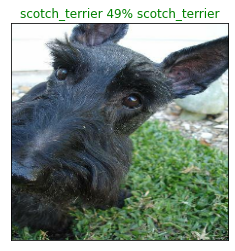

In [ ]:
plot_pred(pred_probablities=predictions, labels=val_labels, images=val_images)

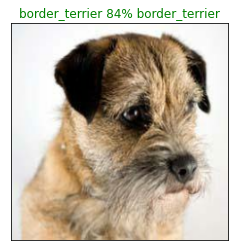

In [ ]:
plot_pred(pred_probablities=predictions, labels=val_labels, images=val_images, n=56)

##### Function to view models top 10 predictions

* Input will be prediction probability array, ground truth array, and an integer
* We'll find the predicted label using pred_label().
* It will find top 10:
  * Prediction probability indexes
  * Prediction probability values
  * Prediction probability labels

* It will then plot those top 10 values and labels. The true label will be colored green

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plot the top 10 highest prediction confidences along with the truth label for 
  sample n.
  """

  pred_prob, true_label = prediction_probabilities[n], labels[n]

  #Get the predicted label
  pred_label = get_pred_label(pred_prob)

  #Find top 10 indexes
  #- argsort viser hvordan et givent array ville væres sorteret, hvis vi 
  #valgte at gøre det.
  #[-10:] viser top 10 values.
  #[::-1] vender resultaterne rundt, så vi nu står med mindst til højest
  #Se eksempel nederst for index 0
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  #Find top 10 confidence values
  top_10_preds_values = pred_prob[top_10_pred_indexes]

  #Find top 10 prediction labels
  top_10_preds_labels = breeds[top_10_pred_indexes]

  #Setup plot
  top_plot = plt.bar(np.arange(len(top_10_preds_labels)),
                     top_10_preds_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_preds_labels)),
             labels=top_10_preds_labels,
             rotation="vertical")
  
  #Change color of true label
  if np.isin(true_label, top_10_preds_labels):
    top_plot[np.argmax(top_10_preds_labels == true_label)].set_color("green")
  else:
    pass

In [ ]:
predictions[0].argsort()

array([ 63,  94,  27,  22,   5,  92, 115,  75,  33,  36,  66, 118, 112,
        16,   1,  55,  42,  46, 113,  61,  30,  99,  44,  86,  24,  12,
        18,  69, 110,   8,  38,  91,  43,  54,   3,  82,  11,  29,  72,
       104, 105,  34, 107,  51,  13,  84,  50,  14, 101,  41, 114, 108,
         4,  49,  47,  48,  19,  60,   7,  25,  56,  58,  45,  53,  40,
        88,  10,   9,  20,  64,  32,  28,  74,  71, 111,  39,  15,  98,
        76, 117,  93,  78,  21,  37,  80,  52, 119,  95,  31,  87,   0,
        57,  89,  62,  97,  81,  23,  90,  67,  96,  85,   2,   6,  83,
       109,  77,  68, 116,  65,  79, 106,  73, 100,  35,  70, 102, 103,
        17,  59,  26])

In [ ]:
predictions[0].argsort()[-10:][::-1]

array([ 26,  59,  17, 103, 102,  70,  35, 100,  73, 106])

In [ ]:
predictions[0]

array([1.22261187e-03, 3.25946457e-05, 5.84850274e-03, 1.13733193e-04,
       1.93608517e-04, 1.33145531e-05, 6.09700149e-03, 2.84595881e-04,
       1.04754297e-04, 3.79058940e-04, 3.47227382e-04, 1.21059238e-04,
       8.35340106e-05, 1.48353880e-04, 1.55303249e-04, 5.27366239e-04,
       2.93887351e-05, 1.58151045e-01, 9.17740981e-05, 2.76908948e-04,
       3.88382963e-04, 8.66594550e-04, 1.29959062e-05, 2.62823142e-03,
       8.19581692e-05, 2.88344803e-04, 2.62177289e-01, 1.09964403e-05,
       4.42789256e-04, 1.29035659e-04, 4.31037915e-05, 1.12027978e-03,
       4.41897690e-04, 2.44989315e-05, 1.36703500e-04, 3.34323682e-02,
       2.49999284e-05, 8.76489503e-04, 1.07796528e-04, 4.91366547e-04,
       3.36714787e-04, 1.61860647e-04, 3.63146537e-05, 1.11299691e-04,
       6.03122971e-05, 3.08601244e-04, 3.82299622e-05, 2.28572040e-04,
       2.52440281e-04, 2.02013587e-04, 1.53104018e-04, 1.44059290e-04,
       8.91113654e-04, 3.10864911e-04, 1.11728114e-04, 3.57646750e-05,
      

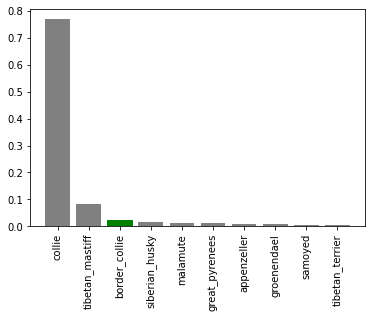

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

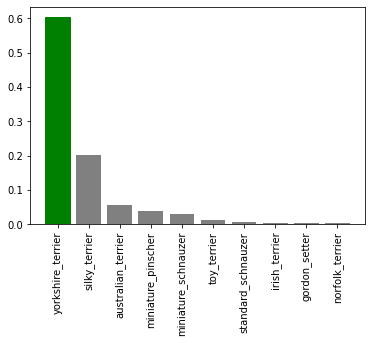

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=12)

##### Combine plot_pred() and plot_pred_conf()


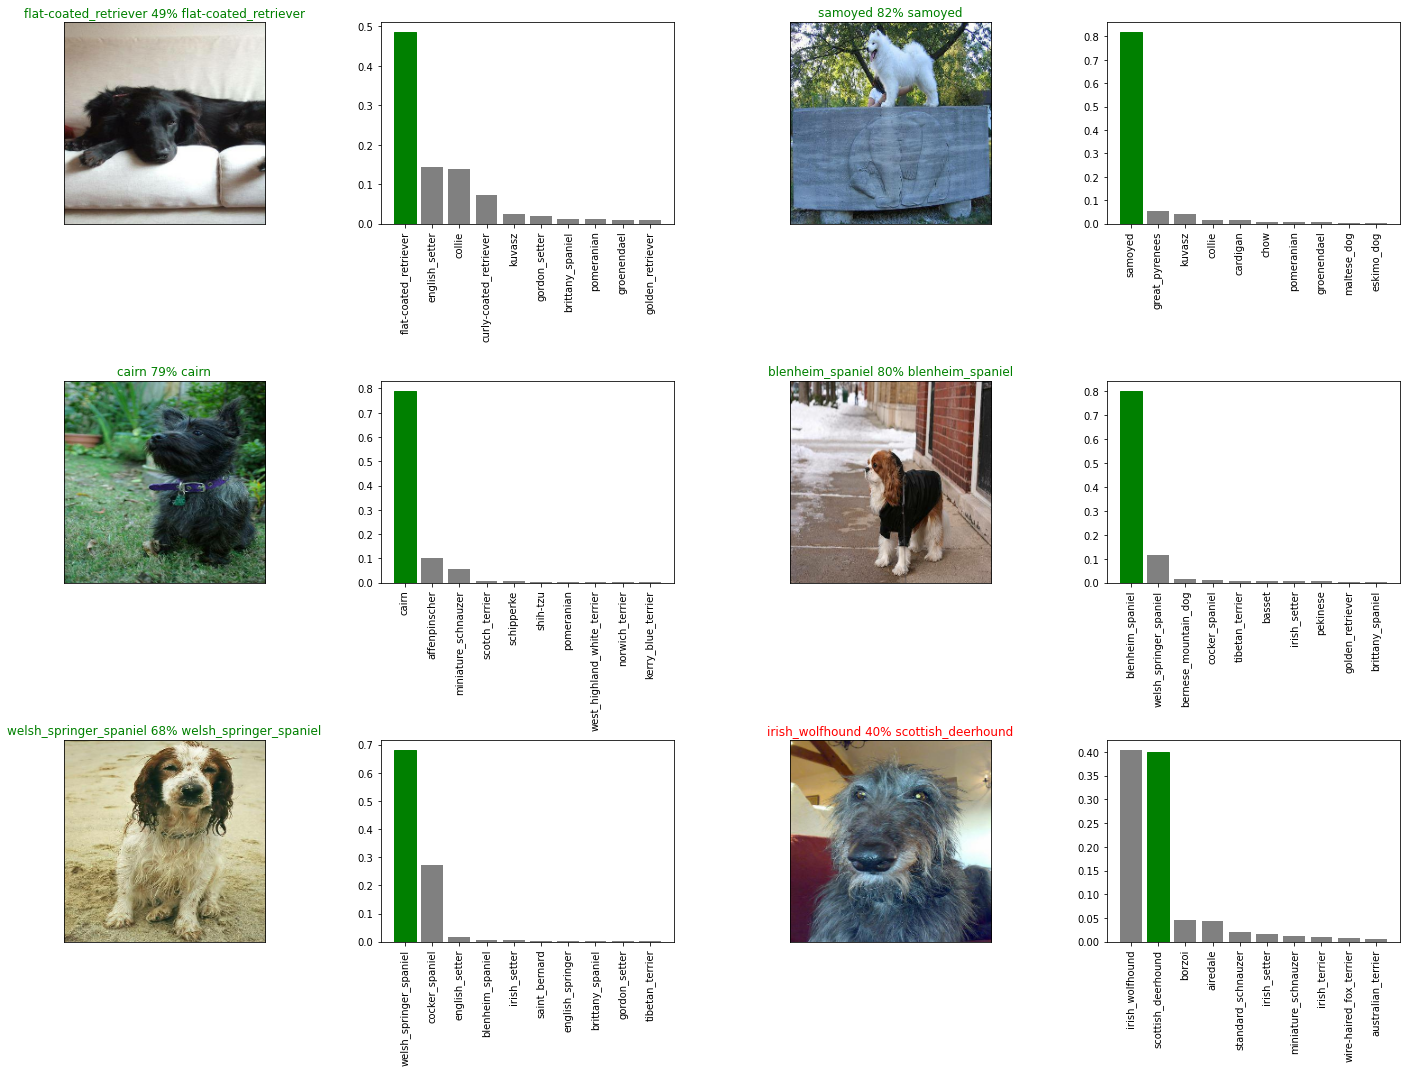

In [ ]:
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols,5*num_rows))

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(pred_probablities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  
  plt.subplot(num_rows,2*num_cols,2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

 # Save and load a trained model

## Save model

In [ ]:
def save_model(model, suffix=None):
  """
  Saves a trained model in the models directory and appends a suffix (string)
  """

  #Create model directory pathname with current time
  modeldir = os.path.join("/content/drive/My Drive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  
  model_path = modeldir + "-" + suffix + ".h5" #save format of model

  print(f"Saving model to {model_path}...")
  model.save(model_path)
  return model_path

## Load model

In [ ]:
  def load_model(model_path):
    """
    Loads a saved model from the specified path
    """

    print(f"Loading model from: {model_path}")
    model = tf.keras.models.load_model(model_path,
                                #Vi har et custom layer, så derfor nedenstående
                                custom_objects={"KerasLayer" : hub.KerasLayer})
    
    return model

In [ ]:
# Test save_model trained on 1000 images

#save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to /content/drive/My Drive/Dog Vision/models/20200807-08461596789989-1000-images-mobilenetv2-Adam.h5...


'/content/drive/My Drive/Dog Vision/models/20200807-08461596789989-1000-images-mobilenetv2-Adam.h5'

In [ ]:
#Test load_model
load_1000_images_model = load_model("/content/drive/My Drive/Dog Vision/models/20200807-08461596789989-1000-images-mobilenetv2-Adam.h5")

Loading model from: /content/drive/My Drive/Dog Vision/models/20200807-08461596789989-1000-images-mobilenetv2-Adam.h5


In [ ]:
#comapre the original model to the loaded model:

#original.
model.evaluate(val_data)

7/7 [==============================] - 1s 150ms/step - loss: 1.2157 - accuracy: 0.6700


[1.2156814336776733, 0.6700000166893005]

In [ ]:
#loaded model:

load_1000_images_model.evaluate(val_data)

7/7 [==============================] - 1s 159ms/step - loss: 1.2157 - accuracy: 0.6700


[1.2156814336776733, 0.6700000166893005]

In [ ]:
#They got same result

# Train model on full data

In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
len(X_train), len(y_train)

(800, 800)

In [ ]:
#Create a databatch with the full dataset
#Also turns data into tensors
full_data = create_data_batches(X, y)

Creating training data batches


In [ ]:
full_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [ ]:
#Create a model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [ ]:
#Create full_model callbacks

full_model_tensorboard = create_tensorboard_callback()

#No validation set when training on all data, so we can't monitor validation
#accuracy.
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

**Note:** Running the cell below will take a little while (might be about 2 hours for first epoch, since the gpu we're using has to load all the images into memory)

In [ ]:
#Fit the full model to the full data
#full_model.fit(x=full_data,
#               epochs=NUM_EPOCHS,
#               callbacks=[full_model_tensorboard,
#                          full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 7397s 23s/step - loss: 1.3243 - accuracy: 0.6709
Epoch 2/100
320/320 [==============================] - 65s 204ms/step - loss: 0.4026 - accuracy: 0.8824
Epoch 3/100
320/320 [==============================] - 66s 205ms/step - loss: 0.2361 - accuracy: 0.9359
Epoch 4/100
320/320 [==============================] - 65s 204ms/step - loss: 0.1541 - accuracy: 0.9634
Epoch 5/100
320/320 [==============================] - 64s 201ms/step - loss: 0.1087 - accuracy: 0.9774
Epoch 6/100
320/320 [==============================] - 63s 197ms/step - loss: 0.0796 - accuracy: 0.9852
Epoch 7/100
320/320 [==============================] - 62s 194ms/step - loss: 0.0590 - accuracy: 0.9913
Epoch 8/100
320/320 [==============================] - 66s 207ms/step - loss: 0.0464 - accuracy: 0.9948
Epoch 9/100
320/320 [==============================] - 64s 199ms/step - loss: 0.0383 - accuracy: 0.9954
Epoch 10/100
320/320 [==============================] - 64s 200m

In [ ]:
#save_model(full_model, suffix="full-dataset-trained-model-mobilenetv2-Adam")

Saving model to /content/drive/My Drive/Dog Vision/models/20200807-11281596799734-full-dataset-trained-model-mobilenetv2-Adam.h5...


'/content/drive/My Drive/Dog Vision/models/20200807-11281596799734-full-dataset-trained-model-mobilenetv2-Adam.h5'

In [ ]:
#Load in full model
loaded_full_model = load_model("/content/drive/My Drive/Dog Vision/models/20200807-11281596799734-full-dataset-trained-model-mobilenetv2-Adam.h5")

Loading model from: /content/drive/My Drive/Dog Vision/models/20200807-11281596799734-full-dataset-trained-model-mobilenetv2-Adam.h5


# Make predictions on the test dataset

We'll be using 'create_data_batches'

In [ ]:
#Load filepaths
test_path = "/content/drive/My Drive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/My Drive/Dog Vision/test/e864f3fc5d19aec4b7a5aa547b359c57.jpg',
 '/content/drive/My Drive/Dog Vision/test/ed9bab128c26470e18631cb6f3454c99.jpg',
 '/content/drive/My Drive/Dog Vision/test/f398e8ff747bfbb95f4aa7660608fc4f.jpg',
 '/content/drive/My Drive/Dog Vision/test/ee76bbe553722f075e334dc29f3173a9.jpg',
 '/content/drive/My Drive/Dog Vision/test/ee3b0ea1f7649dbc3a5724ebccdff863.jpg',
 '/content/drive/My Drive/Dog Vision/test/ec5329231ea816ef212b367bdd17d06c.jpg',
 '/content/drive/My Drive/Dog Vision/test/ea5977763e3e8b39f8ea8c28565d32e3.jpg',
 '/content/drive/My Drive/Dog Vision/test/ea1f200df74cd6c6a458436eedabbc8d.jpg',
 '/content/drive/My Drive/Dog Vision/test/e9c961dc49fdf960fc46c8b54ae1996d.jpg',
 '/content/drive/My Drive/Dog Vision/test/efb4e5dc776a639a140b022cf0835eb5.jpg']

In [ ]:
len(test_filenames)

10357

In [ ]:
len(X)

10222

In [ ]:
#Create test batches
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [ ]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
#Make predictions on the test data

test_predictions = loaded_full_model.predict(test_data, verbose=1)


324/324 [==============================] - 8688s 27s/step


In [ ]:
test_predictions

array([[1.17659560e-07, 1.74080384e-07, 1.38313211e-12, ...,
        1.05465068e-08, 1.19177736e-12, 3.82892440e-10],
       [1.56353428e-06, 1.01593144e-10, 6.47229328e-08, ...,
        2.13555964e-08, 3.54509200e-09, 5.76620414e-06],
       [1.04118270e-09, 7.17710122e-07, 5.93479432e-12, ...,
        3.67325233e-11, 1.07335459e-13, 5.75887471e-12],
       ...,
       [3.23944378e-11, 3.38005339e-04, 1.24632846e-10, ...,
        1.38617756e-10, 8.47530726e-12, 1.76285422e-08],
       [2.35609286e-06, 1.40515724e-12, 8.22763385e-12, ...,
        6.37717310e-11, 1.04973994e-08, 2.04229013e-06],
       [4.81827156e-09, 4.84006435e-09, 2.57031796e-09, ...,
        2.44590748e-08, 1.93007846e-10, 2.62683708e-10]], dtype=float32)

In [ ]:
#Save predictions to csv
np.savetxt("/content/drive/My Drive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [ ]:
#Load predictions
test_predictions_loaded = np.loadtxt("/content/drive/My Drive/Dog Vision/preds_array.csv", delimiter=",")

In [ ]:
test_predictions_loaded

array([[1.17659560e-07, 1.74080384e-07, 1.38313211e-12, ...,
        1.05465068e-08, 1.19177736e-12, 3.82892440e-10],
       [1.56353428e-06, 1.01593144e-10, 6.47229328e-08, ...,
        2.13555964e-08, 3.54509200e-09, 5.76620414e-06],
       [1.04118270e-09, 7.17710122e-07, 5.93479432e-12, ...,
        3.67325233e-11, 1.07335459e-13, 5.75887471e-12],
       ...,
       [3.23944378e-11, 3.38005339e-04, 1.24632846e-10, ...,
        1.38617756e-10, 8.47530726e-12, 1.76285422e-08],
       [2.35609286e-06, 1.40515724e-12, 8.22763385e-12, ...,
        6.37717310e-11, 1.04973994e-08, 2.04229013e-06],
       [4.81827156e-09, 4.84006435e-09, 2.57031796e-09, ...,
        2.44590748e-08, 1.93007846e-10, 2.62683708e-10]])

In [ ]:
test_predictions

array([[1.17659560e-07, 1.74080384e-07, 1.38313211e-12, ...,
        1.05465068e-08, 1.19177736e-12, 3.82892440e-10],
       [1.56353428e-06, 1.01593144e-10, 6.47229328e-08, ...,
        2.13555964e-08, 3.54509200e-09, 5.76620414e-06],
       [1.04118270e-09, 7.17710122e-07, 5.93479432e-12, ...,
        3.67325233e-11, 1.07335459e-13, 5.75887471e-12],
       ...,
       [3.23944378e-11, 3.38005339e-04, 1.24632846e-10, ...,
        1.38617756e-10, 8.47530726e-12, 1.76285422e-08],
       [2.35609286e-06, 1.40515724e-12, 8.22763385e-12, ...,
        6.37717310e-11, 1.04973994e-08, 2.04229013e-06],
       [4.81827156e-09, 4.84006435e-09, 2.57031796e-09, ...,
        2.44590748e-08, 1.93007846e-10, 2.62683708e-10]], dtype=float32)

# Preparing test dataset for Kaggle

* Create dataframe
* column with ID and a column for each dog breed
* For each ID, the prediction probability will be included foreach dogbread for each ID

In [ ]:
#Create pandas dataframe
preds_df = pd.DataFrame(columns=["id"] + list(breeds))

In [ ]:
preds_df.head()

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [ ]:
#Add data
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
test_ids[2]

'f398e8ff747bfbb95f4aa7660608fc4f'

In [ ]:
preds_df["id"] = test_ids

In [ ]:
preds_df.head()

id  ... yorkshire_terrier
0  e864f3fc5d19aec4b7a5aa547b359c57  ...               NaN
1  ed9bab128c26470e18631cb6f3454c99  ...               NaN
2  f398e8ff747bfbb95f4aa7660608fc4f  ...               NaN
3  ee76bbe553722f075e334dc29f3173a9  ...               NaN
4  ee3b0ea1f7649dbc3a5724ebccdff863  ...               NaN

[5 rows x 121 columns]

In [ ]:
#Add the prediction probabilities to each dog breed column
preds_df[list(breeds)] = test_predictions

In [ ]:
preds_df.head()

id  ... yorkshire_terrier
0  e864f3fc5d19aec4b7a5aa547b359c57  ...       3.82892e-10
1  ed9bab128c26470e18631cb6f3454c99  ...        5.7662e-06
2  f398e8ff747bfbb95f4aa7660608fc4f  ...       5.75887e-12
3  ee76bbe553722f075e334dc29f3173a9  ...       1.58073e-06
4  ee3b0ea1f7649dbc3a5724ebccdff863  ...       2.11898e-07

[5 rows x 121 columns]

In [ ]:
#save dataframe to csv
preds_df.to_csv("/content/drive/My Drive/Dog Vision/full-model-predictions-dataframe.csv", index=False)

In [ ]:
pd.read_csv("/content/drive/My Drive/Dog Vision/full-model-predictions-dataframe.csv").head()

id  ...  yorkshire_terrier
0  e864f3fc5d19aec4b7a5aa547b359c57  ...       3.828924e-10
1  ed9bab128c26470e18631cb6f3454c99  ...       5.766204e-06
2  f398e8ff747bfbb95f4aa7660608fc4f  ...       5.758875e-12
3  ee76bbe553722f075e334dc29f3173a9  ...       1.580727e-06
4  ee3b0ea1f7649dbc3a5724ebccdff863  ...       2.118977e-07

[5 rows x 121 columns]

  # Making predictions on custom images


NOTE: Images used is a my german shepherd and a special crossbreed which most likely will be classified as a type of collie.

* Get filepaths
* Turn data into Tensors and data batches with 'create_data_batch()'
* Make predictions

In [ ]:
custom_images_path = "/content/drive/My Drive/Dog Vision/custom_images/"
custom_images_filenames = [custom_images_path + fname for fname in os.listdir(custom_images_path)]
custom_images_filenames

['/content/drive/My Drive/Dog Vision/custom_images/pascal-5.jpg',
 '/content/drive/My Drive/Dog Vision/custom_images/pascal-3.jpg',
 '/content/drive/My Drive/Dog Vision/custom_images/pascal-2.jpg',
 '/content/drive/My Drive/Dog Vision/custom_images/pascal-4.jpg',
 '/content/drive/My Drive/Dog Vision/custom_images/pascal-1.jpg',
 '/content/drive/My Drive/Dog Vision/custom_images/bailey-1.jpg',
 '/content/drive/My Drive/Dog Vision/custom_images/bailey-4.jpg',
 '/content/drive/My Drive/Dog Vision/custom_images/bailey-3.jpg',
 '/content/drive/My Drive/Dog Vision/custom_images/bailey-2.jpg']

In [ ]:
custom_images_batches = create_data_batches(custom_images_filenames, test_data=True)

Creating test data batches...


In [ ]:
custom_images_batches

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
custom_images_predictions = full_model.predict(custom_images_batches, verbose=1)

1/1 [==============================] - 0s 33ms/step


In [ ]:
custom_images_predictions

array([[2.2625894e-09, 2.6769867e-10, 1.9361390e-07, ..., 3.9327511e-10,
        1.0742069e-07, 7.8438381e-11],
       [2.4491670e-10, 2.8999372e-07, 4.5845965e-08, ..., 1.1007034e-09,
        2.0559545e-08, 4.0296171e-09],
       [7.7472348e-11, 7.0616859e-09, 7.7035871e-08, ..., 5.8198046e-10,
        5.2304369e-11, 4.4155044e-11],
       ...,
       [2.8194316e-07, 6.7391008e-09, 8.1687119e-09, ..., 2.3920173e-09,
        1.5544179e-05, 3.3008706e-07],
       [1.3905998e-07, 1.6821292e-10, 9.4775290e-09, ..., 1.5152409e-07,
        6.7662186e-06, 6.9216362e-08],
       [5.5380728e-10, 5.8166002e-12, 6.2608430e-12, ..., 4.3450785e-09,
        7.2243395e-08, 1.8324176e-10]], dtype=float32)

In [ ]:
custom_preds_labels = [get_pred_label(custom_images_predictions[i]) for i in range(len(custom_images_predictions))]

In [ ]:
custom_preds_labels

['german_shepherd',
 'german_shepherd',
 'german_shepherd',
 'german_shepherd',
 'malinois',
 'border_collie',
 'border_collie',
 'border_collie',
 'border_collie']

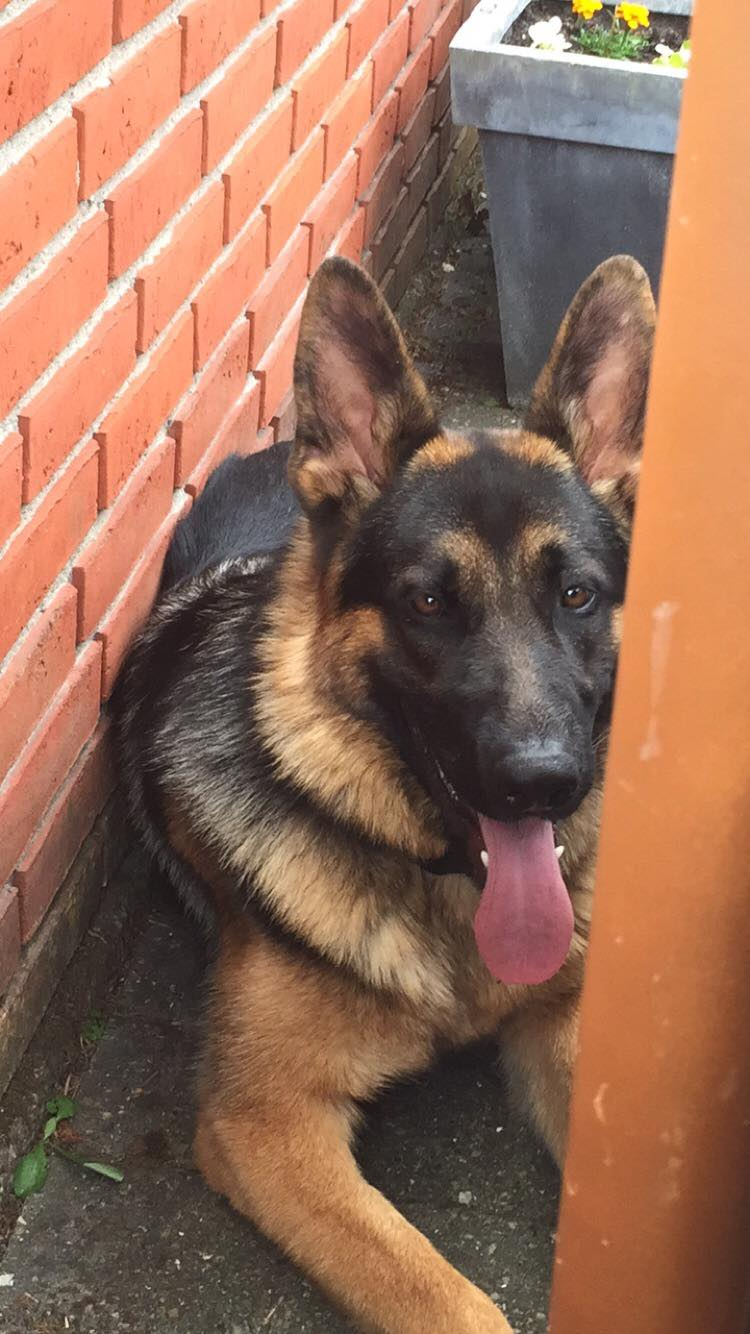

In [ ]:

Image(custom_images_filenames[0])

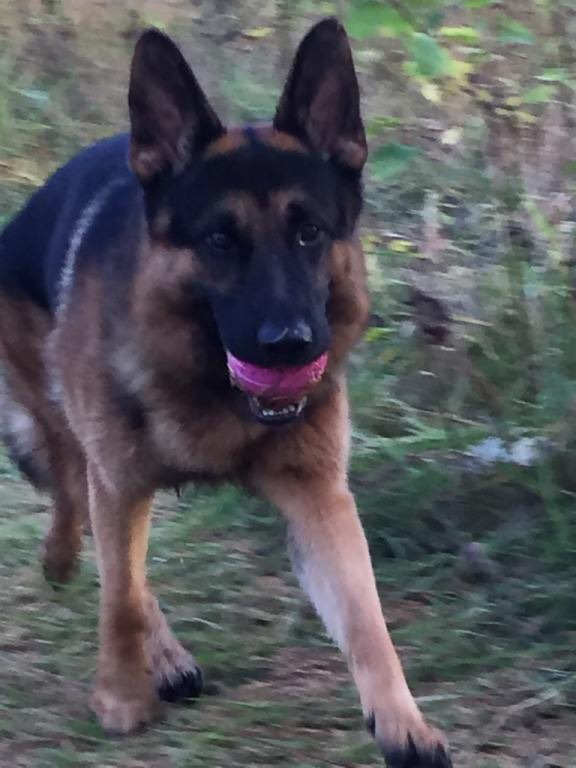

In [ ]:
Image(custom_images_filenames[1])

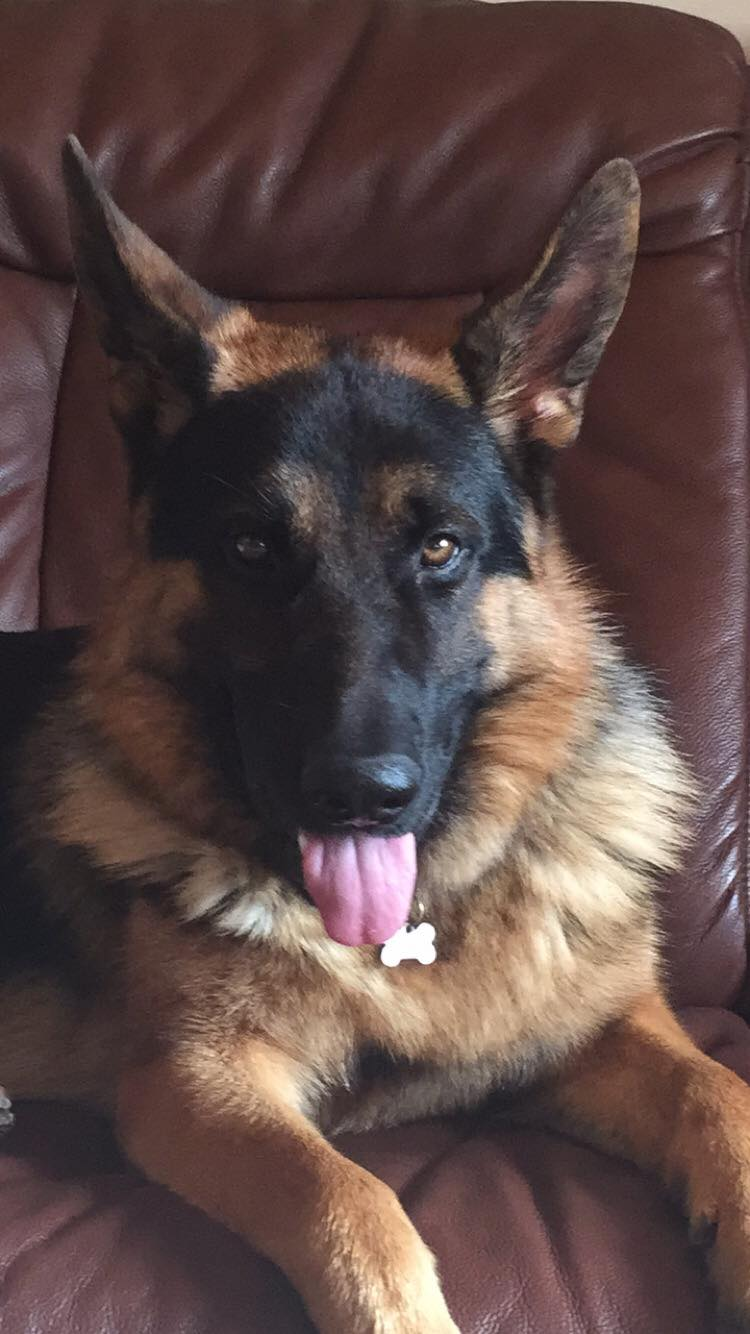

In [ ]:
Image(custom_images_filenames[2])

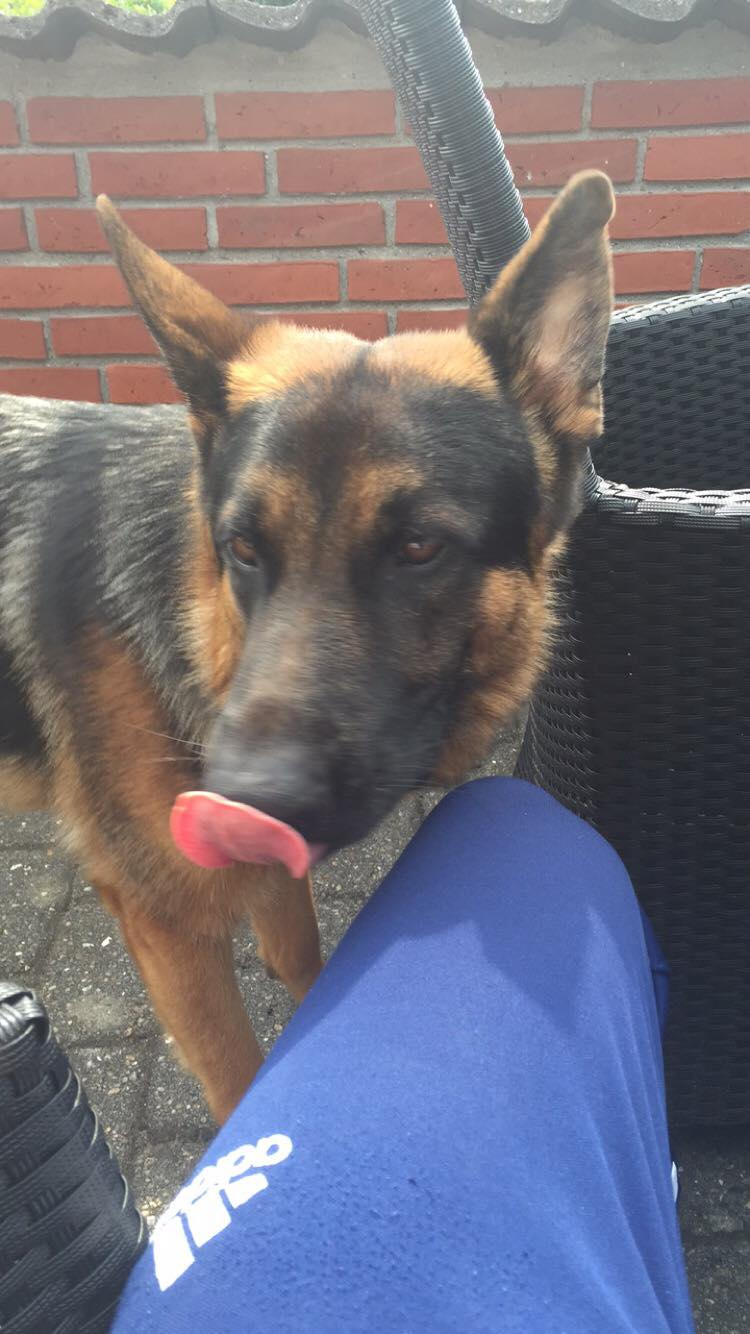

In [ ]:
Image(custom_images_filenames[3])

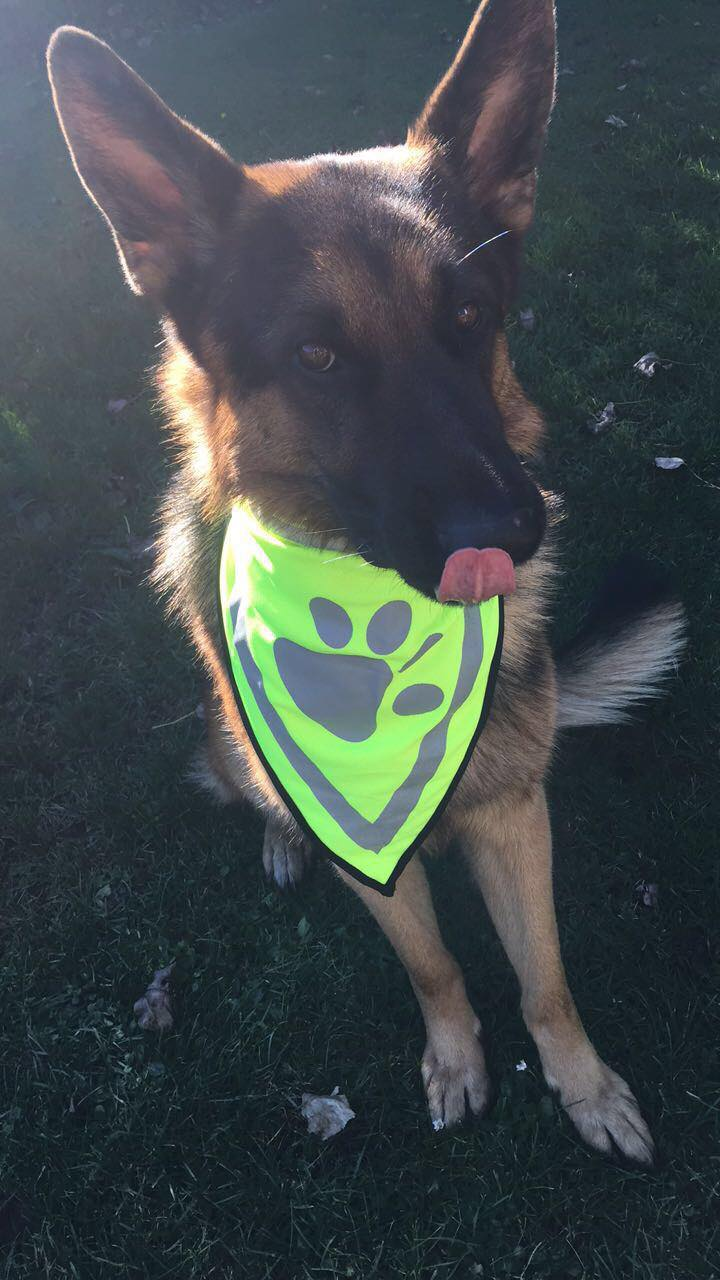

In [ ]:
Image(custom_images_filenames[4])